# Deep Learning based Models for Solar Energy Prediction

## Import all the needed packages

In [1]:
# Basic Data Science Packages
import numpy as np
import pandas as pd

#TensorFlow packages for building DRNN layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Reshape, LSTM, BatchNormalization
from keras.models import Sequential

#Plotting graph
import matplotlib.pyplot as plt

#Plotting Keras Model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)

from keras.utils.vis_utils import plot_model

#Normalization of data
from sklearn.preprocessing import StandardScaler

#Utility Module for computing and displaying metrics
from utility_functions import metrics

import warnings
warnings.filterwarnings("ignore")

## Import the data and split into Train, Test and Validation
- Fetch the first 70% records as train and the rest 15% each as validation and test
    - 8711 * 70% = 6097 records from the start (Train)
    - 6097 + 1307 = 6098 to 7404 records as (Validation)
    - 7404 + 1307 = 7405 to 8711 records as (Test)

In [2]:
thesis_dataset = pd.read_csv('data/final_thesis_dataset.csv',parse_dates=[0], index_col=0)

#Extracting dataset into train, validation and test sets
train = thesis_dataset[:6097]
valid = thesis_dataset[6097:7404]
test = thesis_dataset[7404:]

scaler = StandardScaler()

#Extracting solar and wind X, y columns per set
X_solar_train = train[['SWTDN', 'SWGDN', 'T']]
y_solar_train = train['DE_solar_generation_actual']
X_solar_valid = valid[['SWTDN', 'SWGDN', 'T']]
y_solar_valid = valid['DE_solar_generation_actual']
X_solar_test = test[['SWTDN', 'SWGDN', 'T']]
y_solar_test = test['DE_solar_generation_actual']

X_wind_train = scaler.fit_transform(train[['v1', 'v2', 'v_50m', 'z0']])
y_wind_train = scaler.fit_transform(train['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_valid = scaler.fit_transform(valid[['v1', 'v2', 'v_50m', 'z0']])
y_wind_valid = scaler.fit_transform(valid['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_test = scaler.fit_transform(test[['v1', 'v2', 'v_50m', 'z0']])
y_wind_test = scaler.fit_transform(test['DE_wind_generation_actual'].values.reshape(-1,1))

## Building a DRNN Layer using Recurrent Neural Net with Fully Connected Layer

In [3]:
model = Sequential()
#Mapping to the input size
model.add(Input(shape=(3,)))
#Reshaping for the RNN Layer to perform
model.add(Reshape((-1,1)))
#Creating RNN with 100 units and TanH Activation
model.add(SimpleRNN(100, activation = 'tanh', input_shape = X_solar_train.shape, return_sequences=False))
#Attaching a Dense Layer of the same unit size
model.add(Dense(100))
#Batch Normalization on the output from the dense layer
model.add(BatchNormalization())
#Extracting single output using Dense of 1
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3, 1)              0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,601
Non-trainable params: 200
_________________________________________________________________


## Compiling the model by passing adam optimizer, loss=MAE and fetching accuracy metrics

In [4]:
model.compile('adam', 'mean_absolute_error', ['accuracy'])
history = model.fit(X_solar_train, y_solar_train, epochs = 20, validation_data = (X_solar_valid, y_solar_valid))

Epoch 1/20
191/191 [==============================] - 2s 7ms/step - loss: 4681.7577 - accuracy: 0.3834 - val_loss: 3145.3296 - val_accuracy: 0.0077
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 4568.1136 - accuracy: 0.3917 - val_loss: 3136.4668 - val_accuracy: 0.4682
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 4658.6786 - accuracy: 0.3788 - val_loss: 3098.7495 - val_accuracy: 0.4682
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 4566.1738 - accuracy: 0.3367 - val_loss: 3152.9758 - val_accuracy: 0.4682
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 4675.7505 - accuracy: 0.2827 - val_loss: 3010.6064 - val_accuracy: 0.4682
Epoch 6/20
191/191 [==============================] - 0s 1ms/step - loss: 4571.0970 - accuracy: 0.2558 - val_loss: 2924.7566 - val_accuracy: 0.4682
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 4484.9039 - accuracy: 0.2437 - val_los

In [5]:
model.evaluate(X_solar_test, y_solar_test)

41/41 [==============================] - 0s 776us/step - loss: 684.1048 - accuracy: 0.5907


[684.1047973632812, 0.5906656384468079]

### Plotting Keras model

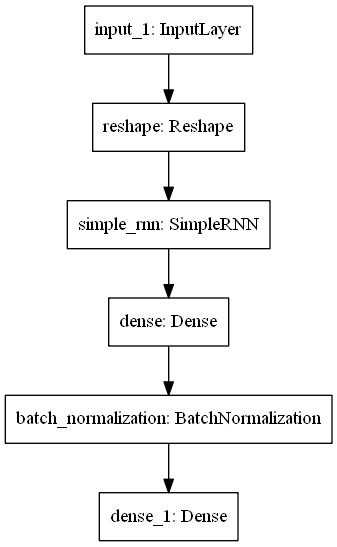

In [6]:
plot_model(
    model, to_file='figs/5-model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## Plotting Model's Accuracy and Loss Metrics over Train and Validation sets for Solar

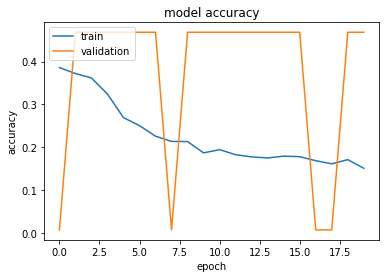

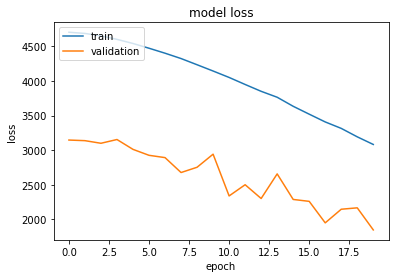

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predictions on the same plot

In [8]:
train_solar_pred = model.predict(X_solar_train)
val_solar_pred = model.predict(X_solar_valid)
test_solar_pred = model.predict(X_solar_test)

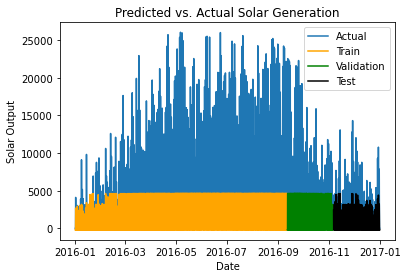

In [9]:
df = thesis_dataset[['DE_solar_generation_actual']]

train_df = train[['DE_solar_generation_actual']]
train_df.loc[:, 'DE_solar_generation_actual'] = train_solar_pred

valid_df = valid[['DE_solar_generation_actual']]
valid_df.loc[:, 'DE_solar_generation_actual'] = val_solar_pred

test_df = test[['DE_solar_generation_actual']]
test_df.loc[:, 'DE_solar_generation_actual'] = test_solar_pred

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_solar_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_solar_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_solar_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")
plt.show()

### Regression Metrics for Solar

In [10]:
metrics('drnn', test[['DE_solar_generation_actual']], test_solar_pred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,684.104842,1420.020259,37.683156,3.629213,0.636459


## Modelling and Fitting the model for Wind Dataset

In [11]:
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Reshape((-1,1)))
model.add(SimpleRNN(100, activation = 'tanh', input_shape = X_solar_train.shape, return_sequences=False))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 4, 1)              0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,601
Non-trainable params: 200
_________________________________________________________________


In [12]:
model.compile('adam', 'mse', ['accuracy'])
history = model.fit(X_wind_train, y_wind_train, validation_data=(X_wind_valid, y_wind_valid), epochs=20)

Epoch 1/20
191/191 [==============================] - 1s 3ms/step - loss: 0.4679 - accuracy: 0.0000e+00 - val_loss: 0.3917 - val_accuracy: 0.0000e+00
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1130 - accuracy: 0.0000e+00 - val_loss: 0.1515 - val_accuracy: 0.0000e+00
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1122 - accuracy: 0.0000e+00 - val_loss: 0.1749 - val_accuracy: 0.0000e+00
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1125 - accuracy: 0.0000e+00 - val_loss: 0.1498 - val_accuracy: 0.0000e+00
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1185 - accuracy: 0.0000e+00 - val_loss: 0.1082 - val_accuracy: 0.0000e+00
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1064 - accuracy: 0.0000e+00 - val_loss: 0.1575 - val_accuracy: 0.0000e+00
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1146 - accuracy: 0.0000e

In [13]:
model.evaluate(X_wind_test, y_wind_test)

41/41 [==============================] - 0s 850us/step - loss: 0.0821 - accuracy: 0.0000e+00


[0.08209418505430222, 0.0]

## Model's Accuracy and Loss for Wind Dataset

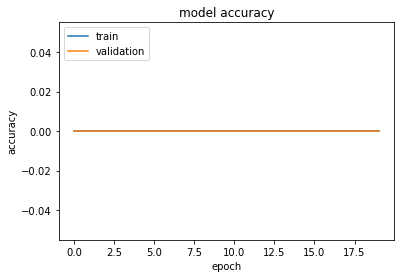

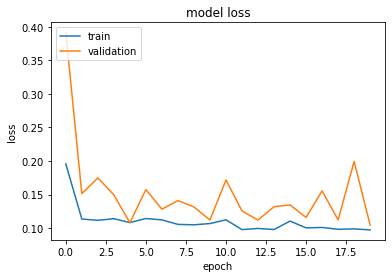

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predicted for Wind on same graph

In [15]:
train_wind_pred = model.predict(X_wind_train)
val_wind_pred = model.predict(X_wind_valid)
test_wind_pred = model.predict(X_wind_test)

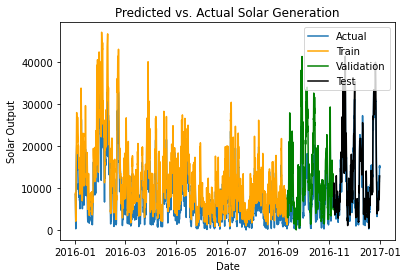

In [16]:
df = thesis_dataset[['DE_wind_generation_actual']]

train_df = train[['DE_wind_generation_actual']]
train_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(train_wind_pred)

valid_df = valid[['DE_wind_generation_actual']]
valid_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(val_wind_pred)

test_df = test[['DE_wind_generation_actual']]
test_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(test_wind_pred)

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_wind_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_wind_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_wind_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Wind Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Wind Generation")
plt.show()

### Regression Metrics for Wind

In [17]:
metrics('drnn', test[['DE_wind_generation_actual']], scaler.inverse_transform(test_wind_pred))

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,1912.239229,2476.848843,49.76795,3.907371,0.917906
